In [130]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    ElasticNet,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [160]:
df = pd.read_pickle("all_tweets_v12.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False
3,1449804331142811655,[],1617597543000440844,2023-01-23 18

# Preprocessing

## Column Types

In [161]:
irrelevant_columns = [
    "author_id",
    "conversation_id",
    "created_at",
    "edit_history_tweet_ids",
    "id",
    "in_reply_to_user_id",
    "referenced_tweets",
    "reply_settings",
    "text",  # incorporated with sentiment analysis, topic modelling
    "quote_count",
    "impression_count",
    "media_keys",  # Incorporated via n_media_keys
    "hashtags",
    "has_hashtags",
    "has_mentions",
    "urls",
    "mentions",
    "cashtags",
    "is_retweet",
    "ratio_like",
    "ratio_retweet",
    "hashtags_flattened",
    "trend_topics",
    "has_media",  # incorporated with n_media
    "is_reply",
    "tweet_type",
    "created_at_day_of_week",  # incorporated by cyclic features
    "created_at_month_of_year",  # incorporated by cyclic features
    "created_at_time_of_day_in_seconds",  # Incorporated by cyclic features
    "media_media_key_1",  # Incorporated via n_media_keys
    "media_media_key_2",  # Incorporated via n_media_keys
    "media_media_key_3",  # Incorporated via n_media_keys
    "media_media_key_4",  # Incorporated via n_media_keys
    "media_height_1",  # incorporated by resolution feature
    "media_height_2",  # incorporated by resolution feature
    "media_height_3",  # incorporated by resolution feature
    "media_height_4",  # incorporated by resolution feature
    "media_width_1",  # incorporated by resolution feature
    "media_width_2",  # incorporated by resolution feature
    "media_width_3",  # incorporated by resolution feature
    "media_width_4",  # incorporated by resolution feature
    "media_public_metrics_1",
    "media_public_metrics_2",
    "media_public_metrics_3",
    "media_public_metrics_4",
    "age_of_account_in_days_author",  # incorporated by "age_of_account_in_days_author_when_tweeted"
    "translated_tweet",
]

additional_irrelevant_columns = [
    "author",  # incorporating it as a categorical variable doesn't add any value
    # Bot score features
    "english",
    "universal",
    "eng_astroturf",
    "eng_fake_follower",
    "eng_financial",
    "eng_other",
    "eng_overall",
    "eng_self_declared",
    "eng_spammer",
    "uni_astroturf",
    "uni_fake_follower",
    "uni_financial",
    "uni_other",
    "uni_overall",
    "uni_self_declared",
    "uni_spammer",
]

# These columns are not available at prediction time
descriptive_columns = [
    "context_annotations",
    "possibly_sensitive",
    "withheld",
    "annotations",
    "media_url_1",
    "media_url_2",
    "media_url_3",
    "media_url_4",
    "media_preview_image_url_1",
    "media_preview_image_url_2",
    "media_preview_image_url_3",
    "media_preview_image_url_4",
    "media_alt_text_1",
    "media_alt_text_2",
    "media_alt_text_3",
    "media_alt_text_4",
    "created_at_year",
]

is_exist_columns = [
    "geo",
    "poll_ids",
]


categorical_columns = [
    "lang",
    "gender_of_author",
    "profession_of_author",
    "majority_lang",
    "media_type_1",
    "media_type_2",
    "media_type_3",
    "media_type_4",
    "sttm_topic",
]

binary_columns = [
    "verified_author",
    "political_context_annotation",
    "posted_during_an_important_event",
]

target_columns = [
    "retweet_count",
    "like_count",
    "reply_count",
]

numerical_columns = [
    "n_trend_topics",
    "text_length",
    "followers_count_author",
    "following_count_author",
    "tweet_count_author",
    "age_of_account_in_days_author_when_tweeted",
    "sentiment",
    "reply_to_tweet_ratio",
    "retweet_to_tweet_ratio",
    "average_tweets_of_author_per_day",
    "media_duration_ms_1",
    "media_duration_ms_2",
    "media_duration_ms_3",
    "media_duration_ms_4",
    "created_at_time_of_day_in_seconds_sin",
    "created_at_time_of_day_in_seconds_cos",
    "n_media_keys",
    "n_hashtags",
    "n_urls",
    "n_mentions",
    "media_resolution_1",
    "media_resolution_2",
    "media_resolution_3",
    "media_resolution_4",
    # emotions
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
]

In [162]:
all_columns = (
    irrelevant_columns
    + additional_irrelevant_columns
    + descriptive_columns
    + is_exist_columns
    + categorical_columns
    + binary_columns
    + target_columns
    + numerical_columns
)
for column_name in all_columns:
    assert all_columns.count(column_name) == 1
assert set(all_columns) == set(df.columns), print(
    set(all_columns).difference(set(df.columns)),
    set(df.columns).difference(set(all_columns)),
)

## Preprocessing columns

In [163]:
preprocessed_df = df.copy()
preprocessed_df.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False
3,1449804331142811655,[],1617597543000440844,2023-01-23 18

In [164]:
preprocessed_df[is_exist_columns] = preprocessed_df[is_exist_columns].isna()
authors = preprocessed_df.author.copy()
preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_columns)
preprocessed_df["author"] = authors
# Impute columns with 0
media_columns_to_input = [
    f"{prefix}_{i}"
    for i in range(1, 5)
    for prefix in ["media_resolution", "media_duration_ms"]
]
for column in [
    "sentiment",
    "reply_to_tweet_ratio",
    "n_media_keys",
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
] + media_columns_to_input:
    preprocessed_df[column].fillna(0, inplace=True)

In [165]:
train_df, validation_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for author in preprocessed_df.author.unique():
    author_df = preprocessed_df[preprocessed_df.author == author].copy()
    author_df.sort_values(by="created_at", inplace=True)
    n_train = int(author_df.shape[0] * 0.8)
    n_validation = int(author_df.shape[0] * 0.1)

    train_df = pd.concat([train_df, author_df.iloc[:n_train].copy()], ignore_index=True)
    validation_df = pd.concat(
        [validation_df, author_df.iloc[n_train : (n_train + n_validation)].copy()],
        ignore_index=True,
    )
    test_df = pd.concat(
        [test_df, author_df.iloc[(n_train + n_validation) :].copy()], ignore_index=True
    )

train_validation_df = pd.concat([train_df, validation_df], ignore_index=True)

In [166]:
train_df.shape, validation_df.shape, train_validation_df.shape, test_df.shape

((72800, 255), (9028, 255), (81828, 255), (9274, 255))

In [167]:
# date_threshold = datetime(2023, 1, 1)

# train_df, test_df = (
#     preprocessed_df[preprocessed_df.created_at < date_threshold],
#     preprocessed_df[preprocessed_df.created_at >= date_threshold],
# )
# train_df.shape, test_df.shape, train_df.shape[0] + test_df.shape[0] == df.shape[0]

In [168]:
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    dataset.drop(columns=irrelevant_columns, inplace=True)
    dataset.drop(columns=descriptive_columns, inplace=True)
    dataset.drop(columns=additional_irrelevant_columns, inplace=True)

In [169]:
# Columns with missing values. This is a simple test and it shouldn't print anything
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    for i in dataset[dataset.isna().any(axis=1)].isna().any().items():
        if i[1]:
            print(i[0])

In [170]:
train_df.head()

,geo,retweet_count,like_count,reply_count,poll_ids,n_trend_topics,text_length,verified_author,followers_count_author,following_count_author,tweet_count_author,sentiment,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_duration_ms_1,media_duration_ms_2,media_duration_ms_3,media_duration_ms_4,political_context_annotation,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,lang_ar,lang_art,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_lt,lang_lv,lang_nl,lang_no,lang_pl,lang_pt,lang_qam,lang_qht,lang_qme,lang_qst,lang_ro,lang_ru,lang_sl,lang_sv,lang_tl,lang_tr,lang_und,lang_vi,lang_zxx,gender_of_author_F,gender_of_author_M,gender_of_author_ORG,gender_of_author_UNKNOWN,profession_of_author_ACADEMICIAN,profession_of_author_ARTIST,profession_of_author_BASKETBALL PLAYER,profession_of_author_DOCTOR,profession_of_author_JOURNALIST,profession_of_author_LAWYER,profession_of_author_NOT AVAILABLE,profession_of_author_POLITICIAN,profession_of_author_TEACHER,profession_of_author_UNKNOWN,profession_of_author_WRITER,majority_lang_en,majority_lang_tr,media_type_1_animated_gif,media_type_1_photo,media_type_1_video,media_type_2_photo,media_type_2_video,media_type_3_photo,media_type_3_video,media_type_4_photo,media_type_4_video,sttm_topic_Uyghurs in China,sttm_topic_activism for nature,sttm_topic_ar,sttm_topic_art,sttm_topic_ca,sttm_topic_ckb,sttm_topic_cs,sttm_topic_cy,sttm_topic_da,sttm_topic_de,"sttm_topic_death, torture, suicide",sttm_topic_decree-law,sttm_topic_democracy,sttm_topic_dismissal of governmental workers,sttm_topic_el,sttm_topic_en,sttm_topic_es,sttm_topic_et,sttm_topic_eu,sttm_topic_expressing wishes,sttm_topic_fa,sttm_topic_fi,sttm_topic_fr,sttm_topic_freedom of speech,sttm_topic_hi,sttm_topic_ht,sttm_topic_hu,sttm_topic_hy,sttm_topic_in,"sttm_topic_inflation, financial instability",sttm_topic_injustice against children,sttm_topic_internatial relations,"sttm_topic_invitation, agenda declaration",sttm_topic_irrelevant tweets,sttm_topic_is,sttm_topic_it,sttm_topic_iw,sttm_topic_lost people,sttm_topic_lt,sttm_topic_lv,sttm_topic_nl,sttm_topic_no,sttm_topic_pl,sttm_topic_politics,sttm_topic_pt,sttm_topic_qam,sttm_topic_qht,sttm_topic_qme,sttm_topic_qst,sttm_topic_ro,sttm_topic_ru,sttm_topic_search for justice,sttm_topic_sl,sttm_topic_supreme court,sttm_topic_sv,sttm_topic_tl,sttm_topic_too_short_tweet,sttm_topic_und,sttm_topic_vi,"sttm_topic_vulnerable, sick people",sttm_topic_woman rights,sttm_topic_zxx
0,True,21,52,4,True,1,48,False,1107.0,174.0,2962.0,0.981266,0.013817,0.435233,1.231915,0.0,0.0,0.0,0.0,False,0.500000,-0.866025,0.0,1,0,0,0.0,0.0,0.0,0.0,0.200000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,92.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,31,53,4,True,1,58,False,1107.0,174.0,2962.0,0.992877,0.013817,0.435233,1.231915,0.0,0.0,0.0,0.0,False,-0.737277,-0.675590,0.0,1,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,92.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,True,7,11,3,True,1,128,False,1107.0,174.0,

# Modelling

In [171]:
def split_x_and_y(input_df):
    x = input_df[[c for c in input_df.columns if c not in target_columns]].copy()
    y = input_df[[c for c in input_df.columns if c in target_columns]].copy()
    return x, y


x_train, y_train = split_x_and_y(train_df)
x_validation, y_validation = split_x_and_y(validation_df)
x_train_validation, y_train_validation = split_x_and_y(train_validation_df)
x_test, y_test = split_x_and_y(test_df)

print(
    x_train.shape,
    x_validation.shape,
    x_train_validation.shape,
    x_test.shape,
    y_train.shape,
    y_validation.shape,
    y_train_validation.shape,
    y_test.shape,
)

(72800, 171) (9028, 171) (81828, 171) (9274, 171) (72800, 3) (9028, 3) (81828, 3) (9274, 3)


In [172]:
for y in [y_train, y_validation, y_train_validation, y_test]:
    y["log_like_count"] = y.like_count.apply(lambda x: np.log(max(1, x)))
    if y.equals(y_train):
        print("Calculating lambda value for box-cox...")
        y["box_cox_like_count"], lambda_value = stats.boxcox(
            y.like_count.apply(lambda x: max(1, x))
        )
    else:
        y["box_cox_like_count"] = stats.boxcox(
            y.like_count.apply(lambda x: max(1, x)), lambda_value
        )
    y["square_root_like_count"] = y.like_count.apply(np.sqrt)

Calculating lambda value for box-cox...


In [173]:
def calculate_metrics(y_true, y_predicted):
    mae = metrics.mean_absolute_error(y_true, y_predicted)
    mse = metrics.mean_squared_error(y_true, y_predicted)
    r2 = metrics.r2_score(y_true, y_predicted)
    return mae, mse, r2

In [187]:
def back_transform_predictions(y_predicted, target_column):
    if target_column == "log_like_count":
        y_predicted = np.exp(y_predicted)
    elif target_column == "box_cox_like_count":
        y_predicted = (y_predicted * lambda_value + 1) ** (1 / lambda_value)
    elif target_column == "square_root_like_count":
        y_predicted = y_predicted**2
    return y_predicted


def evaluate(model, model_name, x, y_true, dataset_name, target_column):
    print("Predicting with the trained model")

    y_predicted = model.predict(x)
    y_predicted = back_transform_predictions(y_predicted, target_column)
    try:
        mae, mse, r2 = calculate_metrics(y_true, y_predicted)
    except ValueError:
        print("Error happened due to nan values.")
        return np.inf, np.inf, 0
    print(f"The {model_name} model performance for {dataset_name} set")
    print("--------------------------------------")
    print(f"MAE is {mae}")
    print(f"MSE is {mse}")
    print(f"R2 score is {r2}\n\n")
    return mae, mse, r2


def fine_tune_model(param_grid, model_class, model_name):
    model = model_class()
    best_r2 = 0
    best_params = None
    best_model = None
    for params in param_grid:
        target_column = params["target_column"]
        print(f"\n\nTraining {model_name} with params: {params}...\n\n")
        model.set_params(**{k: v for k, v in params.items() if k != "target_column"})
        model.fit(x_train, y_train[target_column])

        mae, mse, r2 = evaluate(
            model,
            model_name,
            x_validation,
            y_validation.like_count,
            "validation",
            target_column,
        )
        if r2 > best_r2:
            best_r2 = r2
            best_params = params
            best_model = model
    print(f"Found best params: {best_params}")
    return best_params, best_r2, best_model


def train_best_model(model_class, model_name, param_grid):
    best_params, best_r2, best_model = fine_tune_model(
        param_grid, model_class, model_name
    )
    # best_params = {
    #     "n_estimators": 1000,
    #     "n_jobs": -1,
    #     "random_state": 0,
    #     "target_column": "square_root_like_count",
    # }

    target_column = best_params["target_column"]
    evaluate(
        model,
        model_name,
        x_train_validation,
        y_train_validation.like_count,
        "train_and_validation",
        target_column,
    )
    evaluate(model, model_name, x_test, y_test.like_count, "test", target_column)
    return best_model, best_params["target_column"]

In [188]:
RANDOM_STATE = 0
random_forest_param_grid = ParameterGrid(
    {
        "n_estimators": [50, 200, 1000],
        "random_state": [RANDOM_STATE],
        "n_jobs": [-1],
        "target_column": [
            "square_root_like_count",
            "box_cox_like_count",
            "like_count",
            "log_like_count",
        ],
    }
)
# rf_model, target_column = train_best_model(
#     RandomForestRegressor, "RandomForestRegressor", random_forest_param_grid
# )

elastic_net_param_grid = ParameterGrid(
    {
        "random_state": [RANDOM_STATE],
        "l1_ratio": [0.3, 0.5, 0.7],
        "max_iter": [1000, 2000],
        "copy_X": [True],
        "selection": ["cyclic", "random"],
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            # "log_like_count",
        ],
    }
)
# elastic_net_model, target_column = train_best_model(ElasticNet, "ElasticNet", elastic_net_param_grid)

linear_regression_param_grid = ParameterGrid(
    {
        "copy_X": [True],
        "n_jobs": [-1],
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            # "log_like_count",
        ],
    }
)
# linear_regression_model, target_column = train_best_model(
#     LinearRegression, "LinearRegression", linear_regression_param_grid
# )

xgboost_param_grid = ParameterGrid(
    {
        "n_estimators": [100],
        "max_depth": [20, 30, 40],
        "eta": [0.3, 0.5],
        "subsample": [0.7],
        "colsample_bytree": [0.9],
        "n_jobs": [-1],
        "random_state": RANDOM_STATE,
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            "log_like_count",
        ],
    }
)
xgboost_best_params = {
    "colsample_bytree": 0.9,
    "eta": 0.3,
    "max_depth": 20,
    "n_estimators": 100,
    "n_jobs": -1,
    "subsample": 0.7,
    "target_column": "square_root_like_count",
}
xgboost_model, target_column = train_best_model(
    xgboost.XGBRFRegressor, "XGBRFRegressor", xgboost_param_grid
)



Training XGBRFRegressor with params: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'subsample': 0.7, 'target_column': 'square_root_like_count'}...


Predicting with the trained model
The XGBRFRegressor model performance for validation set
--------------------------------------
MAE is 144.163479331691
MSE is 805703.4443271138
R2 score is 0.5270536570456015




Training XGBRFRegressor with params: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'subsample': 0.7, 'target_column': 'log_like_count'}...


Predicting with the trained model
The XGBRFRegressor model performance for validation set
--------------------------------------
MAE is 139.88144426493452
MSE is 894768.0525458857
R2 score is 0.4747729065531998




Training XGBRFRegressor with params: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 30, 'n_estimators': 100, 'n_jobs': -1, 'subsample': 0.7, 'target_column': 'square_root_like_count'}...



In [189]:
model = xgboost_model
model_name = "XGBRFRegressor"

In [190]:
evaluate(
    model,
    model_name,
    x_train_validation,
    y_train_validation.like_count,
    "train_validation",
    target_column,
)
evaluate(model, model_name, x_test, y_test.like_count, "test", target_column)

Predicting with the trained model
The XGBRFRegressor model performance for train_validation set
--------------------------------------
MAE is 207.29946262957927
MSE is 1805319.9725668265
R2 score is -0.01257148515602946


Predicting with the trained model
The XGBRFRegressor model performance for test set
--------------------------------------
MAE is 223.42290455930487
MSE is 1684400.5765083916
R2 score is -0.019058777830916362




(223.42290455930487, 1684400.5765083916, -0.019058777830916362)

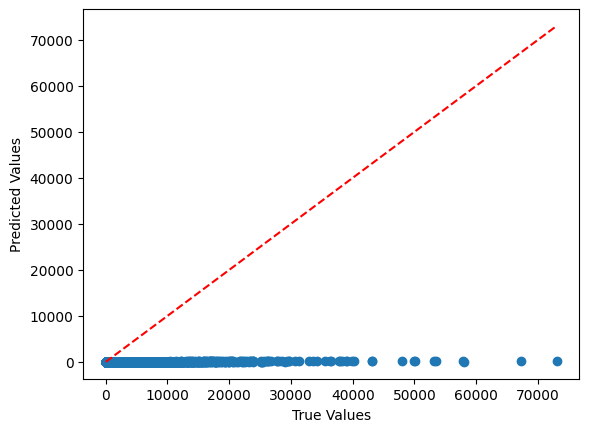

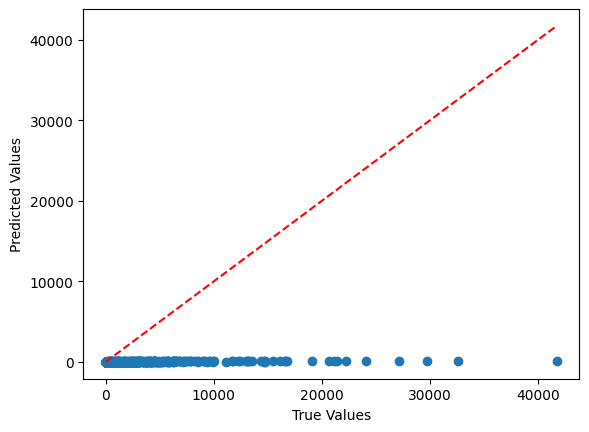

In [191]:
y_train_validation_predicted = model.predict(x_train_validation)
y_test_predicted = model.predict(x_test)

y_train_validation_predicted = back_transform_predictions(
    y_train_validation_predicted, "square_root_like_count"
)
y_test_predicted = back_transform_predictions(
    y_test_predicted, "square_root_like_count"
)


# plot the predicted values against the true values
def plot_predicted_vs_true(y_true, y_predicted):
    plt.scatter(y_true.like_count, y_predicted)
    plt.plot(
        [min(y_true.like_count), max(y_true.like_count)],
        [min(y_true.like_count), max(y_true.like_count)],
        "--",
        color="red",
    )
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()


plot_predicted_vs_true(y_train_validation, y_train_validation_predicted)
plot_predicted_vs_true(y_test, y_test_predicted)

# TODO

1. Outlier Detection
2. Done - Different model architectures - Try to overfit on training set
    - RANSAC
    - SVR
    - XGBoost
3. Shapley values for black-box models
4. Done - Better train test split
5. Done -  Calculate age of the account according to tweet date
6. Done - Include important events as a feature
7. Done - Better model evaluation
8. Not needed - Box cox transformation based on train_validation
9. Create a dataframe for fine tuning
10. Literature Review
    - TFIDF
    - Word Embeddings

In [95]:
import numpy as np

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

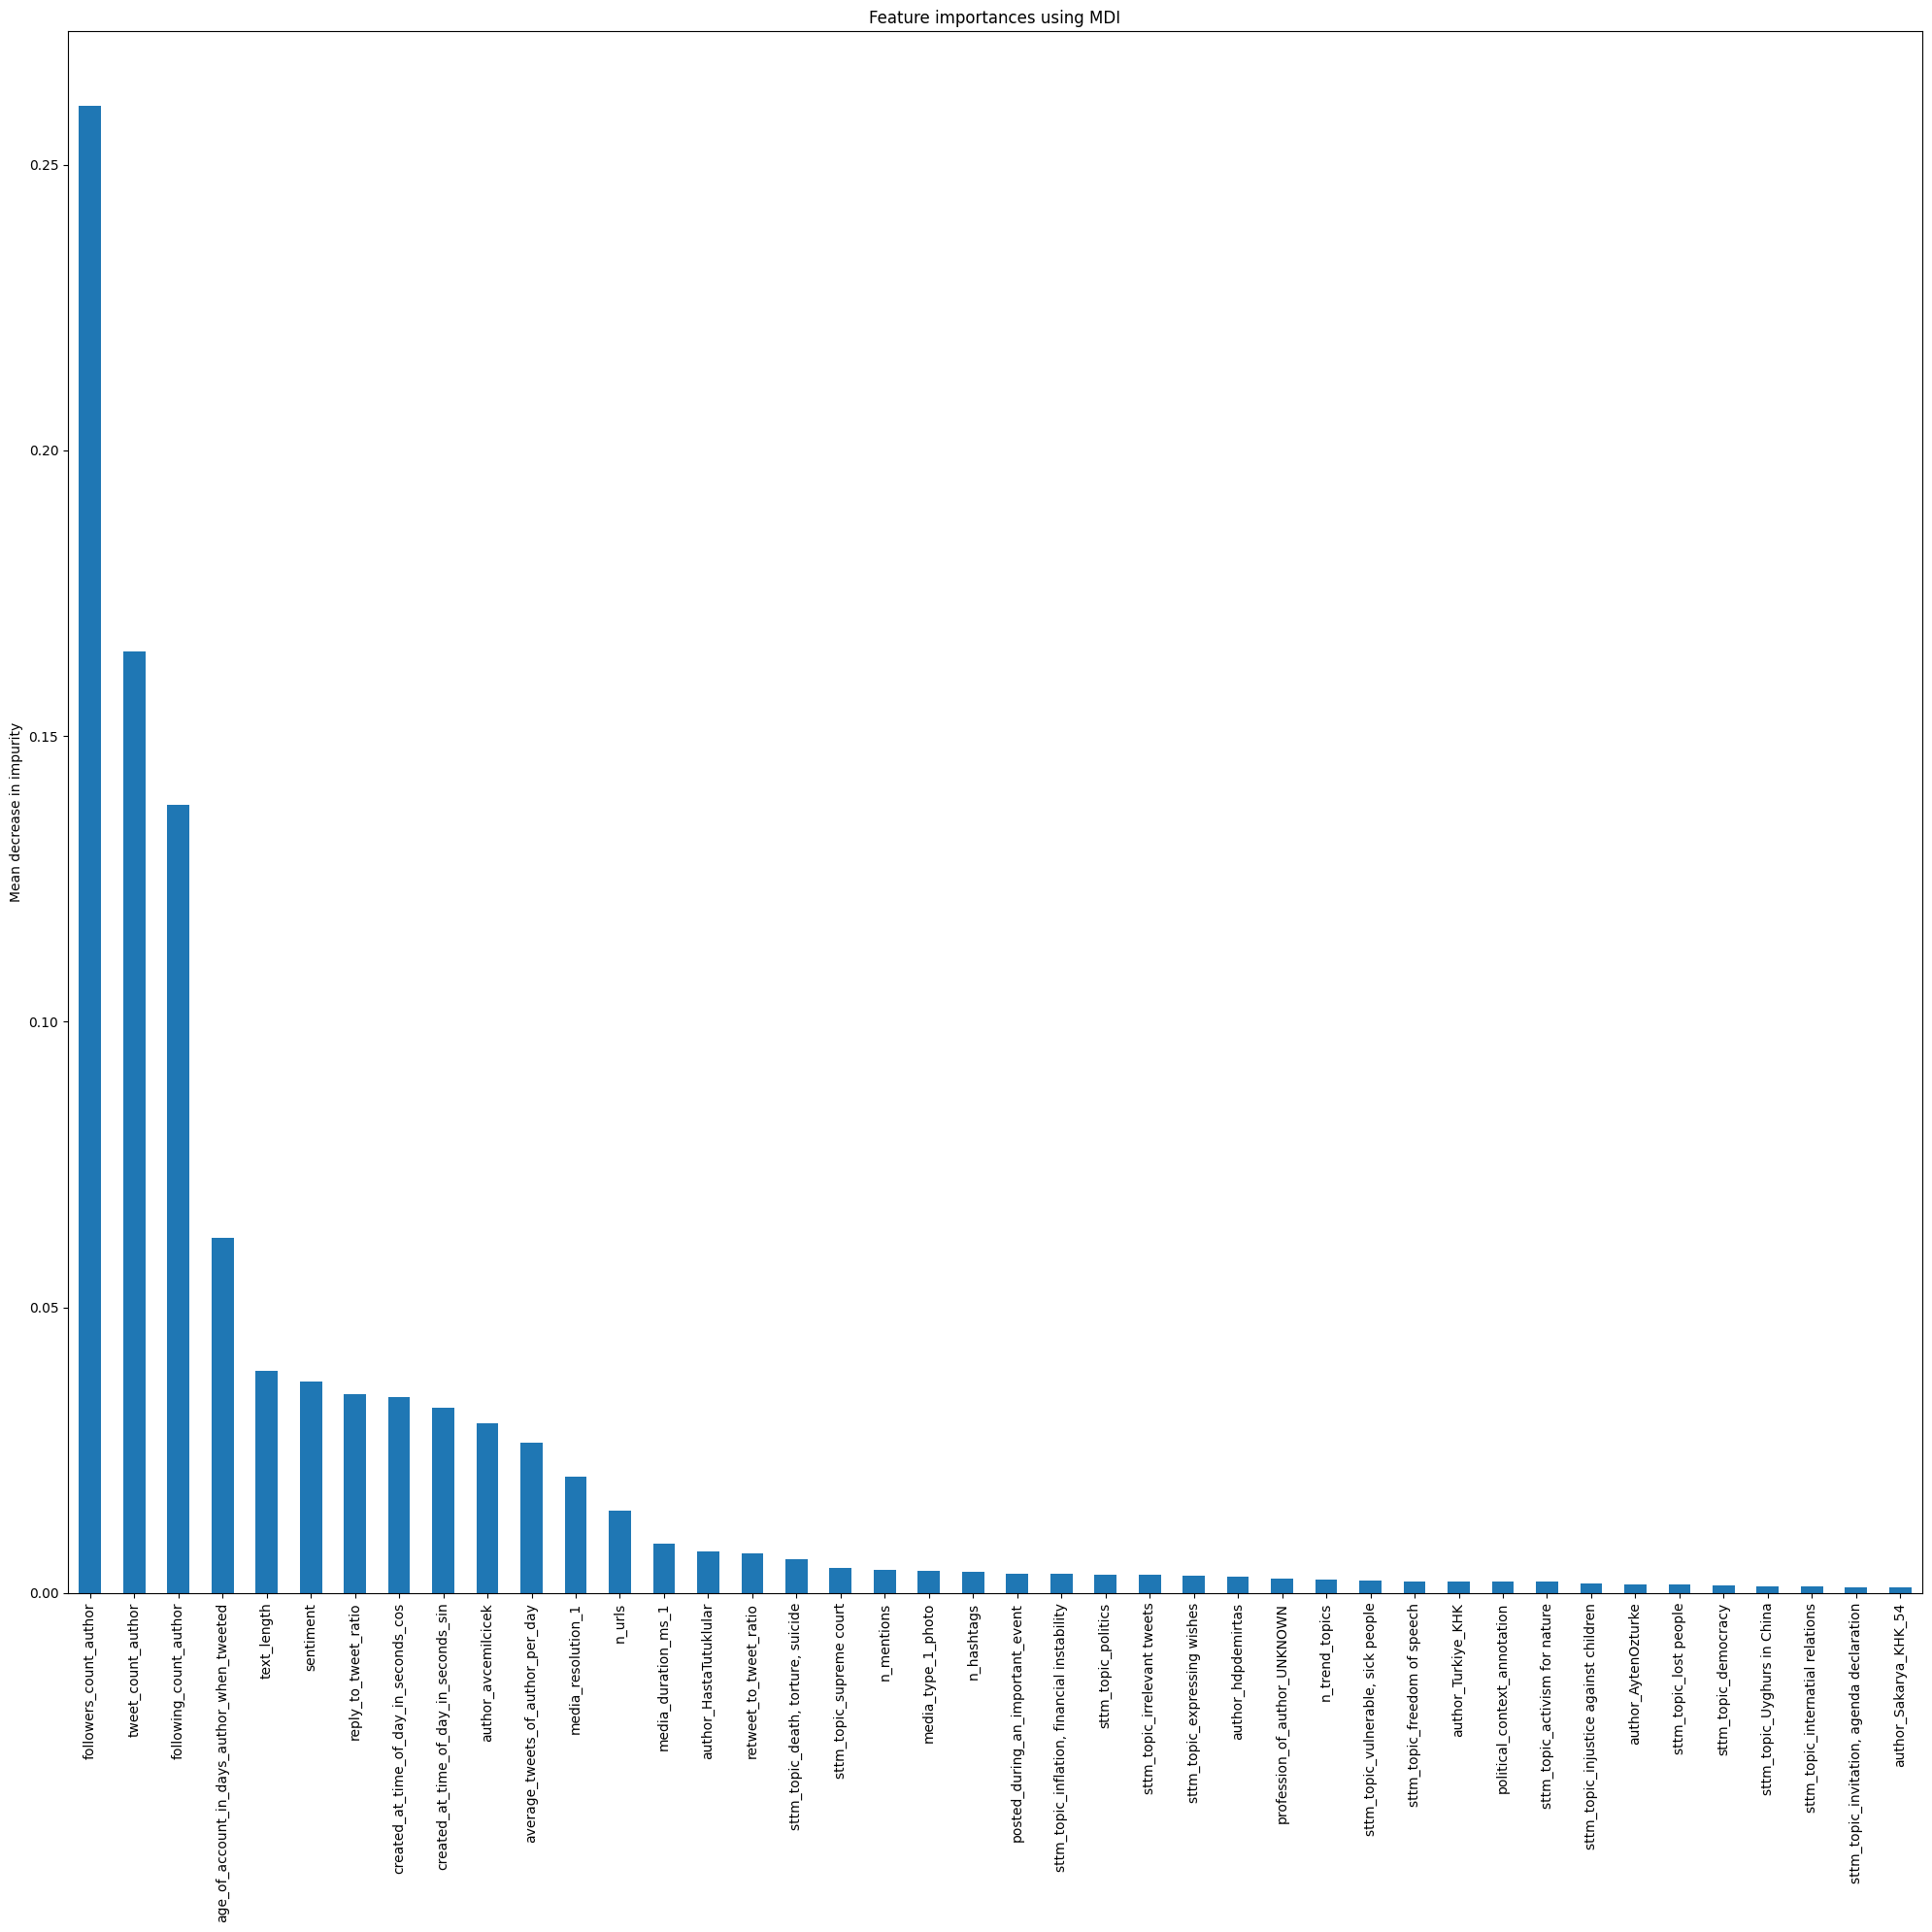

In [96]:
import pandas as pd

forest_importances = pd.Series(importances, index=x_train.columns)

filter_threshold = 0.001
filtered_importances = forest_importances[forest_importances > filter_threshold]
filtered_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))
# filtered_importances.drop(
#     index=[ind for ind in filtered_importances.index if ind.startswith("author")]
# ).plot.bar(ax=ax)
filtered_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("feature_importances.png")  # save the figure to file

In [106]:
# # def fit_and_evaluate(model_name, model_params, target_column):
# #     model_class, params = model_params
# #     model = model_class(**params)
# #     print("Training the model")
# #     # model.fit(x_train, y_train[target_column])
# #     model.fit(x_train_validation, y_train_validation[target_column])

# #     evaluate(model, model_name, x_train, y_train[target_column], "training")
# #     evaluate(model, model_name, x_validation, y_validation[target_column], "validation")
# #     evaluate(
# #         model,
# #         model_name,
# #         x_train_validation,
# #         y_train_validation[target_column],
# #         "validation",
# #     )
# #     evaluate(model, model_name, x_test, y_test[target_column], "test")

# #     return model

# model_classes = {
#     # "decision_tree": (DecisionTreeRegressor, {"random_state": 0}),
#     # "linear_regression": (LinearRegression, {}),
#     # "random_forest": (
#     #     RandomForestRegressor,
#     #     {"n_estimators": 50, "random_state": 0, "n_jobs": -1, "verbose": 1},
#     # ),
#     "random_forest": (
#         RandomForestRegressor,
#         {"n_estimators": 1000, "random_state": 0, "n_jobs": -1},
#     ),
# }

# target_column = "box_cox_like_count"  #  "square_root_like_count", "box_cox_like_count", "like_count",  "log_like_count"
# models = {}
# for model_name, params in model_classes.items():
#     models[model_name] = fit_and_evaluate(model_name, params, target_column)

In [42]:
models["linear_regression"].coef_

# feature_names = models["linear_regression"].get_feature_names_out()
#
coefs = pd.DataFrame(
    models["linear_regression"].coef_,
    columns=["Coefficients"],
    index=models["linear_regression"].feature_names_in_,
)

coefs.sort_values(by="Coefficients")

,Coefficients
english,-4.044454e+08
author_TurkishFacade,-1.382039e+08
uni_fake_follower,-9.147412e+07
author__IHRAA,-6.664118e+07
author_Vezirkopru_KHK,-5.862585e+07
uni_other,-5.040683e+07
author_Kars_KHK,-3.799343e+07
author_Golbasi_KHK,-3.557841e+07
author_KHKAVRUPA,-3.226584e+07
author_Elazig_KHK,-3.187294e+07
